# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import heapq
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts)
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin

# https://en.wikipedia.org/wiki/OPTICS_algorithm
class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.epsilon = kwargs["epsilon"]
        self.min_pts = kwargs["min_pts"]
        self.core_distances = {}
        self.reachability_distances = {}
        self.processed = set()
        self.ordered = []
        self.clusters = []

    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        def get_neighbours_with_distances(p, tree):
            neighbours, distances = tree.query_radius([p], self.epsilon, return_distance=True, sort_results=True)
            
            # p is counted as its own neighbour with a zero distance
            neighbours, distances = [x[0][1:] for x in (neighbours, distances)]
            return [tuple(X[np.array(x)]) for x in neighbours], distances

        def get_core_dist(p, neighbours, distances):
            if p in self.core_distances:
                return self.core_distances[p]
            elif len(neighbours) >= self.min_pts:
                self.core_distances[p] = distances[self.min_pts - 1]
                return get_core_dist(p, neighbours, distances)
            else:
                return None

        def update_heap(heap, p, distance):
            heap_contents = list(heap)
            while heap:
                heapq.heappop(heap)
            for elem in heap_contents:
                old_distance, point = elem
                if p != point:
                    heapq.heappush(heap, elem)
            heapq.heappush(heap, (distance, p))

        def update(p, core_distance, neighbours, heap):
            for n in neighbours:
                if n not in self.processed:
                    reachability_distance = max(core_distance, np.linalg.norm(np.array(p) - np.array(n)))
                    if n not in self.reachability_distances:
                        self.reachability_distances[n] = reachability_distance
                        heapq.heappush(heap, (reachability_distance, n))
                    else:
                        if reachability_distance < self.reachability_distances[n]:
                            self.reachability_distances[n] = reachability_distance
                            update_heap(heap, n, reachability_distance)
        tree = KDTree(X)
        for entry in X:
            row = tuple(entry) # ndarray is unhashable
            if row in self.processed:
                continue

            neighbours, distances = get_neighbours_with_distances(row, tree)
            self.processed.add(row)
            self.ordered.append(row)
            core_distance = get_core_dist(row, neighbours, distances)
            if core_distance:
                heap = []
                heapq.heapify(heap)
                update(row, core_distance, neighbours, heap)
                while heap:
                    _, n = heapq.heappop(heap)
                    new_neighbours, new_distances = get_neighbours_with_distances(n, tree)
                    self.processed.add(n)
                    self.ordered.append(n)
                    new_core_distance = get_core_dist(n, new_neighbours, new_distances)
                    if new_core_distance:
                        update(n, new_core_distance, new_neighbours, heap)
                        
        clusters = []
        cluster = []

        for i in range(len(self.ordered)):
            p = self.ordered[i]
            reachability_distance = self.reachability_distances[p] if p in self.reachability_distances else None

            if not reachability_distance or reachability_distance > self.epsilon:
                if cluster:
                    clusters.append(cluster[:])
                    cluster = []
            cluster.append(p)
        if cluster:
            clusters.append(cluster)

        self.clusters = [set(x) for x in clusters if len(x) >= self.min_pts]

        return self

    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        result = []
        for entry in X:
            cluster_assigned = False
            row = tuple(entry)
            for i in range(len(self.clusters)):
                cluster = self.clusters[i]
                if row in cluster:
                    result.append(i)
                    cluster_assigned = True
                    break
            if not cluster_assigned:
                result.append(-1)

        return result

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

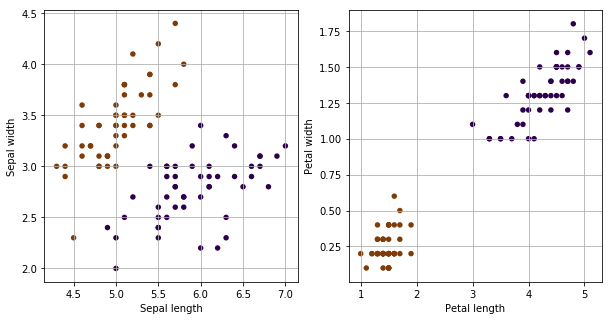

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.grid()

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.grid()

pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [4]:
pred_iris = Clustering(epsilon=0.7, min_pts=4).fit_predict(x_iris) # picked by hand
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

In [5]:
def mean_sorted_dist_for_n_neighbours(X, n):
        tree = KDTree(X)
        return sorted([tree.query([row], k=n+1)[0][0][1:].mean() for row in X])

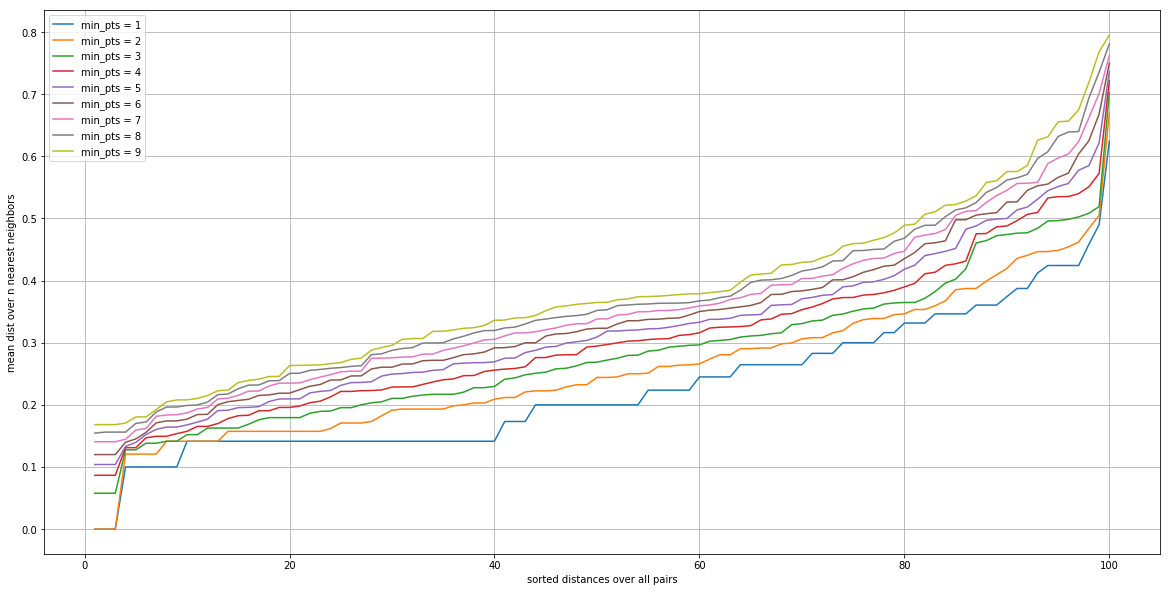

In [6]:
plt.figure(figsize=(20, 10))
plt.xlabel("sorted distances over all pairs")
plt.ylabel('mean dist over n nearest neighbors')

x = list(range(1, len(x_iris) + 1))

for min_pts in list(range(1, 10)):
    distances = mean_sorted_dist_for_n_neighbours(x_iris, min_pts)
    plt.plot(x, distances, label="min_pts = {}".format(min_pts))
    
plt.grid()
plt.legend()
plt.show()

Looks like "Elbow" happens somewhere at 0.5-0.65, depending on `min_pts` parameter.

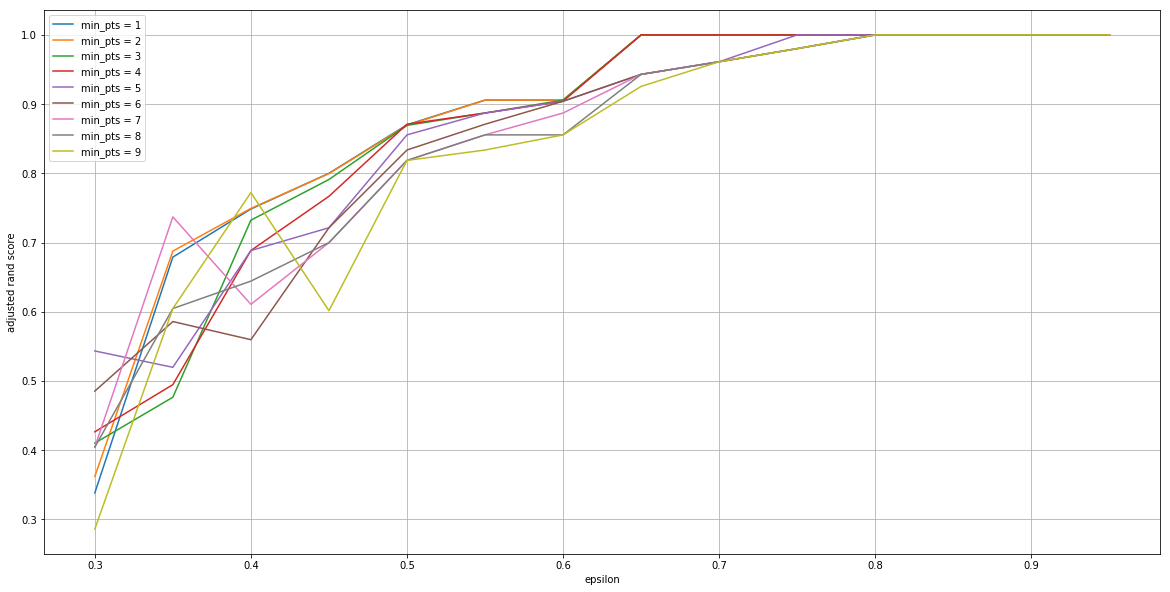

In [7]:
ars = smt.adjusted_rand_score
epsilons = list(x / 100 for x in range(30, 100, 5))
fig = plt.figure(figsize=(20, 10))

plt.xlabel("epsilon")
plt.ylabel("adjusted rand score")

for min_pts in list(range(1, 10)):
    result = [ars(Clustering(min_pts=min_pts, epsilon=eps).fit_predict(x_iris), y_iris) for eps in epsilons]
    plt.plot(epsilons, result, label="min_pts = {}".format(min_pts))

plt.grid()
plt.legend()
plt.show()

It's clear that the best Adjusted Rand Score for this dataset is achieved with `min_pts`=1...4 and `epsilon`=0.65+ or `min_pts`=5+ and `epsilon`=0.75+.

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

In [8]:
# let's automate things a bit
def find_best_params(X, y):
    min_pts = list(range(1, 10))
    distances_for_n = [mean_sorted_dist_for_n_neighbours(X, i) for i in min_pts]
    elbow_epsilons = []
    for distances in distances_for_n:
        diffs = []
        for i in range(1, len(distances)):
            diffs.append(distances[i] - distances[i-1])
        max_diff_idx = np.array(diffs).argmax()
        elbow_epsilons.append(distances[max_diff_idx-1])
    best_ars = 0
    best_params = (min_pts[0], epsilons[0])
    for pts, eps in zip(min_pts, elbow_epsilons):
        ars = smt.adjusted_rand_score(Clustering(epsilon=eps, min_pts=pts).fit_predict(X), y)
        if ars > best_ars:
            best_ars = ars
            best_params = (pts, eps)
            if ars == 1.0:
                break
    return best_params

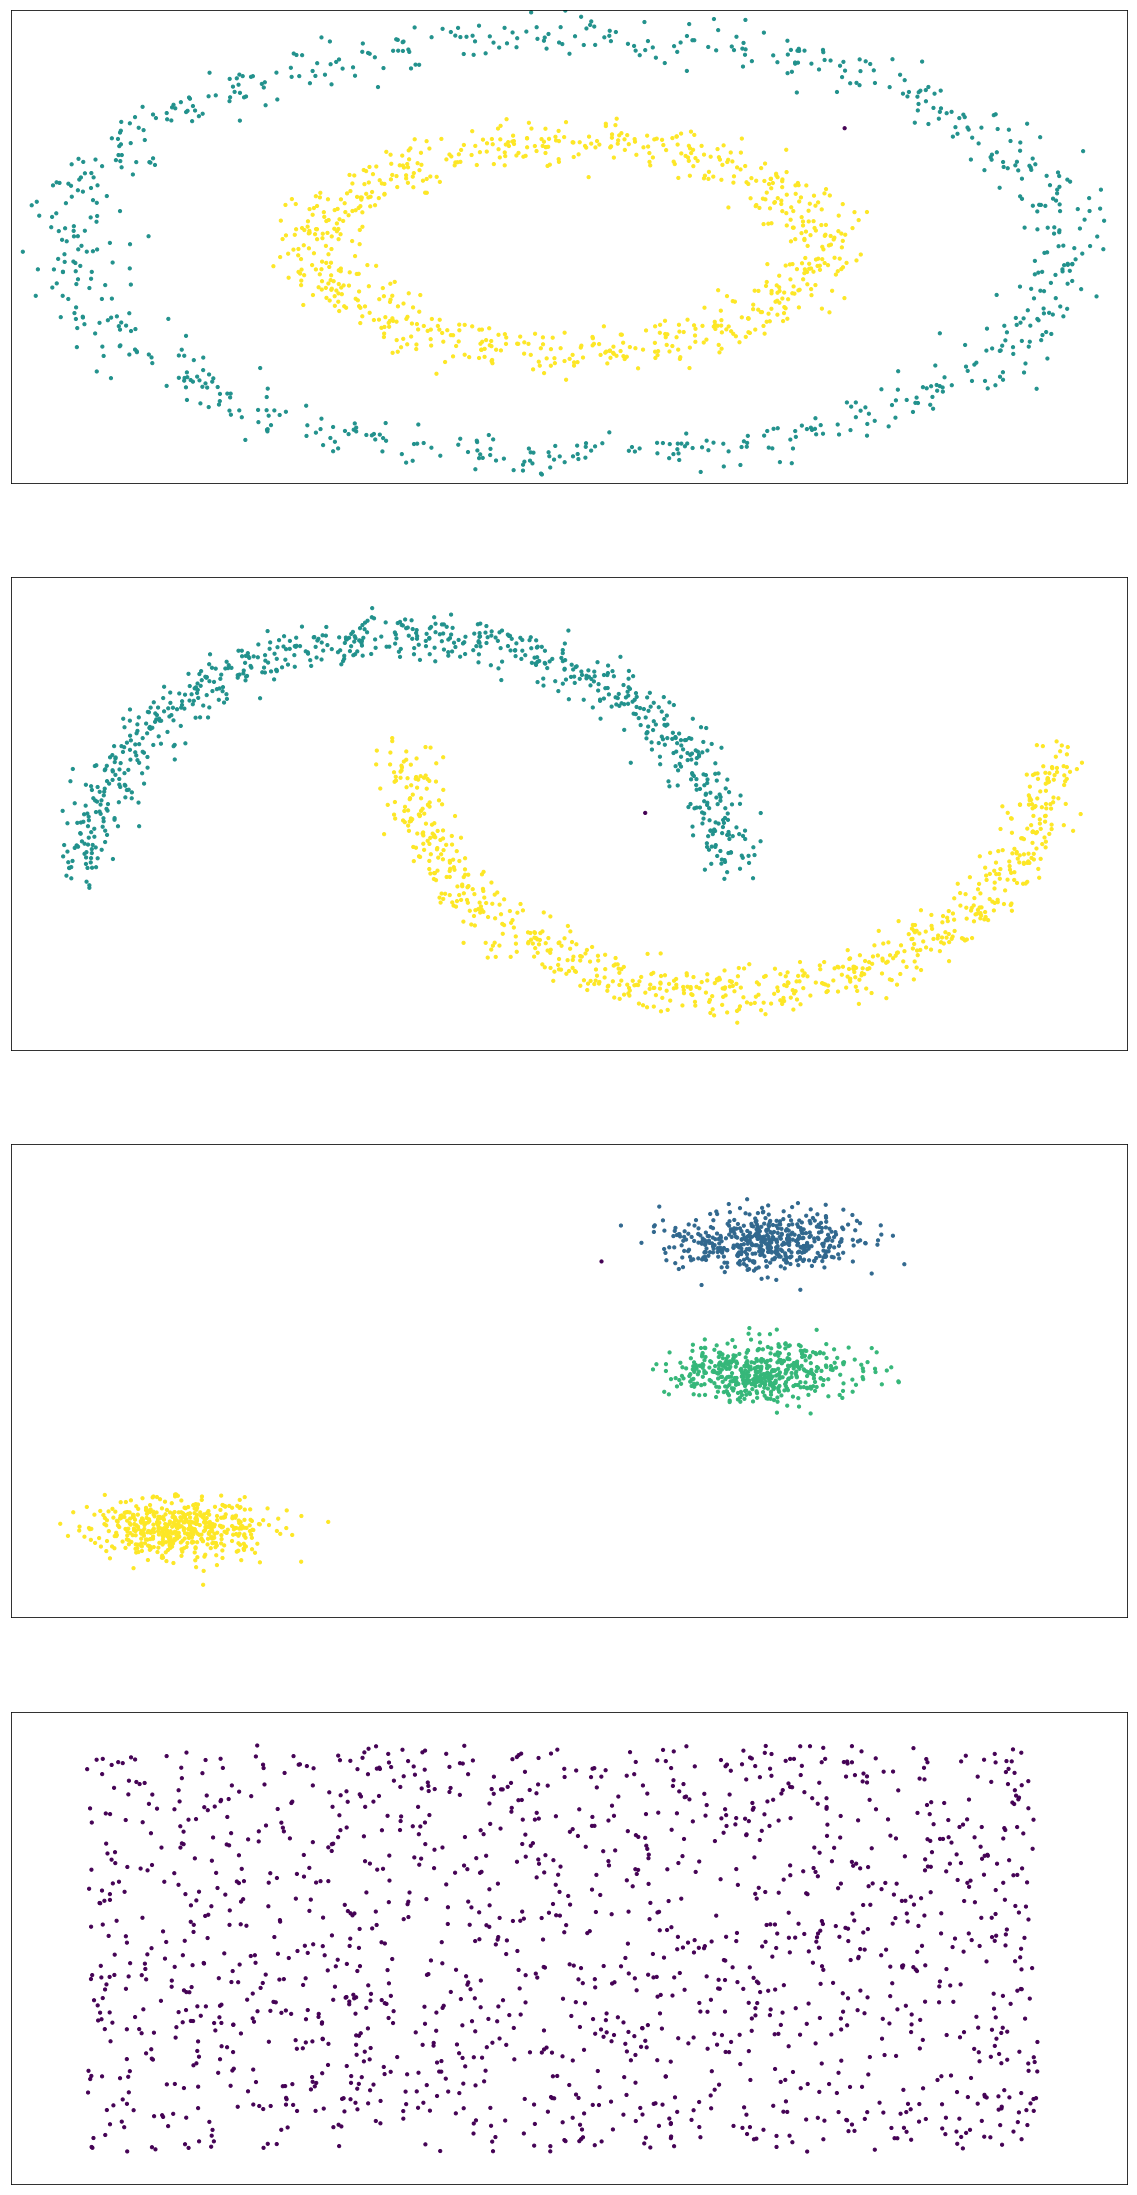

In [9]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=0)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=0)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), [-1] * n_samples
data = [noisy_circles, noisy_moons, blobs, no_structure]

plt.figure(figsize=(20, 10*len(data)))

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    min_pts, epsilon = find_best_params(X, y)
    predicted = Clustering(min_pts=min_pts, epsilon=epsilon).fit_predict(X)
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=predicted)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()